### Seelct a function to approximate

## Harmonic oscillator

The harmonic oscillator is governed by the second-order ordinary differential equation:
$$
\frac{d^2 x}{dt^2} + \omega^2 x = 0
$$

The harmonic oscillator can be reformulated as a system of first-order differential equations:
$$
\begin{cases}
\frac{dx_1}{dt} = x_2 \\
\frac{dx_2}{dt} = -\omega^2 x_1
\end{cases}
$$
where:
$$
x_1 = x, \quad x_2 = \frac{dx}{dt}
$$

The initial conditions for this system are:
$$
x_1(0) = x_{1,0}, \quad x_2(0) = x_{2,0}
$$

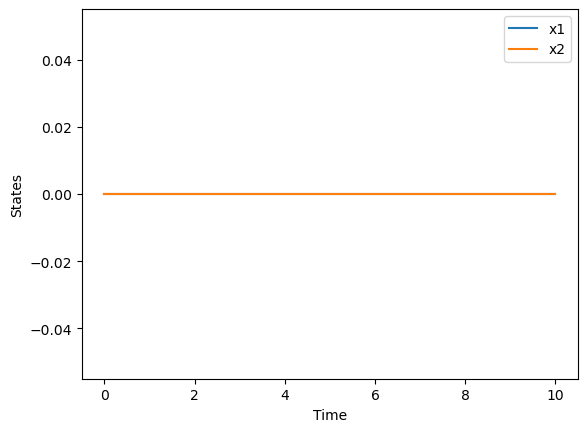

In [10]:
import numpy as np
import jax
import jax.numpy as jnp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define parameters
omega = 1.0
T = 10  # Total time
N = 100  # Number of discretization points
degree = 3  # Degree of the polynomial

# Collocation points
tau_root = np.append(0, np.polynomial.legendre.leggauss(degree)[0])

# Coefficients of the collocation equation
C = np.zeros((degree+1, degree+1))
D = np.zeros(degree+1)
B = np.zeros(degree+1)

# Construct polynomial basis
for j in range(degree+1):
    # Construct the Lagrange polynomial
    L = np.poly1d([1])
    for r in range(degree+1):
        if r != j:
            L *= np.poly1d([1, -tau_root[r]]) / (tau_root[j] - tau_root[r])
    D[j] = L(1.0)
    Ldot = np.polyder(L)
    for r in range(degree+1):
        C[j, r] = Ldot(tau_root[r])
    integral_L = np.polyint(L)
    B[j] = integral_L(1.0)

# Time points
h = T / N
t = np.linspace(0, T, N+1)

# Initial conditions
x1_0 = 1.0
x2_0 = 0.0

# System dynamics
def f(x1, x2):
    return jnp.array([x2, -omega**2 * x1])

# Objective function to minimize (no control input for harmonic oscillator, so this is trivial)
def objective(vars):
    return 0

# Constraints
def constraints(vars):
    X1 = vars[:N+1]
    X2 = vars[N+1:2*(N+1)]
    
    g = []
    g.append(X1[0] - x1_0)
    g.append(X2[0] - x2_0)
    
    for k in range(N):
        X1k_end = D[0] * X1[k]
        X2k_end = D[0] * X2[k]
        for j in range(1, degree+1):
            xp1 = C[0, j] * X1[k]
            xp2 = C[0, j] * X2[k]
            for r in range(1, degree+1):
                xp1 += C[r, j] * vars[2*(N+1) + (k*degree + r - 1)]
                xp2 += C[r, j] * vars[2*(N+1) + (k*degree + r - 1)]
            fk = f(vars[2*(N+1) + (k*degree + j - 1)], vars[2*(N+1) + (k*degree + j - 1)])
            g.append(h * fk[0] - xp1)
            g.append(h * fk[1] - xp2)
            X1k_end += D[j] * vars[2*(N+1) + (k*degree + j - 1)]
            X2k_end += D[j] * vars[2*(N+1) + (k*degree + j - 1)]
        g.append(X1[k+1] - X1k_end)
        g.append(X2[k+1] - X2k_end)
    
    return jnp.array(g)

# Initial guess
vars0 = np.zeros(2*(N+1) + N*degree)

# Solve the problem using SciPy's minimize function
solution = minimize(objective, vars0, constraints={'type': 'eq', 'fun': constraints}, method='SLSQP')

# Extract solution
vars_opt = solution.x
X1_opt = vars_opt[:N+1]
X2_opt = vars_opt[N+1:2*(N+1)]

# Plot results
plt.figure()
plt.plot(t, X1_opt, label='x1')
plt.plot(t, X2_opt, label='x2')
plt.xlabel('Time')
plt.ylabel('States')
plt.legend()
plt.show()


In [4]:
import numpy as np
from casadi import *
import matplotlib.pyplot as plt

### Define parameters

In [ ]:
mu = 1.0
T = 10  # Total time
N = 100  # Number of discretization points
degree = 3  # Degree of the polynomial

In [6]:
# Collocation points
tau_root = np.append(0, np.array(collocation_points(degree, 'legendre')))

In [7]:
tau_root

array([0.        , 0.11270167, 0.5       , 0.88729833])

In [8]:
# Coefficients of the collocation equation
C = np.zeros((degree+1, degree+1))
D = np.zeros(degree+1)
B = np.zeros(degree+1)

In [3]:
# Construct polynomial basis
for j in range(degree+1):
    # Construct the Lagrange polynomial
    L = np.poly1d([1])
    for r in range(degree+1):
        if r != j:
            L *= np.poly1d([1, -tau_root[r]]) / (tau_root[j] - tau_root[r])
    D[j] = L(1.0)
    Ldot = np.polyder(L)
    for r in range(degree+1):
        C[j, r] = Ldot(tau_root[r])
    integral_L = np.polyint(L)
    B[j] = integral_L(1.0)

# Time points
h = T / N
t = np.linspace(0, T, N+1)

# Declare variables
X1 = MX.sym('X1', N+1)
X2 = MX.sym('X2', N+1)
U = MX.sym('U', N)

# Collocation variables
X1c = [MX.sym(f'X1c_{j}') for j in range(degree)]
X2c = [MX.sym(f'X2c_{j}') for j in range(degree)]

# Initial conditions
x1_0 = 2.0
x2_0 = 0.0

# System dynamics
def f(x1, x2, u):
    return vertcat(x2, mu * (1 - x1**2) * x2 - x1)

# Create the collocation equations
g = []
g.append(X1[0] - x1_0)
g.append(X2[0] - x2_0)

for k in range(N):
    X1k_end = D[0] * X1[k]
    X2k_end = D[0] * X2[k]
    for j in range(1, degree+1):
        xp1 = C[0, j] * X1[k]
        xp2 = C[0, j] * X2[k]
        for r in range(1, degree+1):
            xp1 += C[r, j] * X1c[r-1]
            xp2 += C[r, j] * X2c[r-1]
        [fk1, fk2] = f(X1c[j-1], X2c[j-1], U[k])
        g.append(h * fk1 - xp1)
        g.append(h * fk2 - xp2)
        X1k_end += D[j] * X1c[j-1]
        X2k_end += D[j] * X2c[j-1]
    g.append(X1[k+1] - X1k_end)
    g.append(X2[k+1] - X2k_end)

g = vertcat(*g)

# Create NLP
w = vertcat(X1, X2, U, vertcat(*X1c), vertcat(*X2c))
nlp = {'x': w, 'f': dot(U, U), 'g': g}
solver = nlpsol('solver', 'ipopt', nlp)

# Initial guess
w0 = np.zeros((N+1)*2 + N + degree*2)

# Solve NLP
sol = solver(x0=w0, lbg=0, ubg=0)

# Extract solution
X1_opt = np.array(sol['x'][0:N+1])
X2_opt = np.array(sol['x'][N+1:2*(N+1)])
U_opt = np.array(sol['x'][2*(N+1):2*(N+1)+N])

# Plot results
plt.figure()
plt.plot(t, X1_opt, label='x1')
plt.plot(t, X2_opt, label='x2')
plt.xlabel('Time')
plt.ylabel('States')
plt.legend()
plt.show()


Exception: CasADi matrices are not iterable by design.
                      Did you mean to iterate over m.nz, with m IM/DM/SX?
                      Did you mean to iterate over horzsplit(m,1)/vertsplit(m,1) with m IM/DM/SX/MX?
                      

In [9]:
import numpy as np
import jax
import jax.numpy as jnp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define parameters
mu = 1.0
T = 10  # Total time
N = 100  # Number of discretization points
degree = 3  # Degree of the polynomial

# Collocation points
tau_root = np.append(0, np.polynomial.legendre.leggauss(degree)[0])

# Coefficients of the collocation equation
C = np.zeros((degree+1, degree+1))
D = np.zeros(degree+1)
B = np.zeros(degree+1)

# Construct polynomial basis
for j in range(degree+1):
    # Construct the Lagrange polynomial
    L = np.poly1d([1])
    for r in range(degree+1):
        if r != j:
            L *= np.poly1d([1, -tau_root[r]]) / (tau_root[j] - tau_root[r])
    D[j] = L(1.0)
    Ldot = np.polyder(L)
    for r in range(degree+1):
        C[j, r] = Ldot(tau_root[r])
    integral_L = np.polyint(L)
    B[j] = integral_L(1.0)

# Time points
h = T / N
t = np.linspace(0, T, N+1)

# Initial conditions
x1_0 = 2.0
x2_0 = 0.0

# System dynamics
def f(x1, x2, u):
    return jnp.array([x2, mu * (1 - x1**2) * x2 - x1])

# Objective function to minimize
def objective(vars):
    U = vars[:N]
    X1 = vars[N:N+N+1]
    X2 = vars[N+N+1:]
    
    cost = jnp.sum(U**2)
    return cost

# Constraints
def constraints(vars):
    U = vars[:N]
    X1 = vars[N:N+N+1]
    X2 = vars[N+N+1:]
    
    g = []
    g.append(X1[0] - x1_0)
    g.append(X2[0] - x2_0)
    
    for k in range(N):
        X1k_end = D[0] * X1[k]
        X2k_end = D[0] * X2[k]
        for j in range(1, degree+1):
            xp1 = C[0, j] * X1[k]
            xp2 = C[0, j] * X2[k]
            for r in range(1, degree+1):
                xp1 += C[r, j] * vars[N+N+1 + r-1]
                xp2 += C[r, j] * vars[N+N+1 + r-1]
            fk = f(vars[N+N+1 + j-1], vars[N+N+1 + j-1], U[k])
            g.append(h * fk[0] - xp1)
            g.append(h * fk[1] - xp2)
            X1k_end += D[j] * vars[N+N+1 + j-1]
            X2k_end += D[j] * vars[N+N+1 + j-1]
        g.append(X1[k+1] - X1k_end)
        g.append(X2[k+1] - X2k_end)
    
    return jnp.array(g)

# Initial guess
vars0 = np.zeros(2*(N+1) + N)

# Solve the problem using SciPy's minimize function
solution = minimize(objective, vars0, constraints={'type': 'eq', 'fun': constraints}, method='SLSQP')

# Extract solution
vars_opt = solution.x
U_opt = vars_opt[:N]
X1_opt = vars_opt[N:N+N+1]
X2_opt = vars_opt[N+N+1:]

# Plot results
plt.figure()
plt.plot(t, X1_opt, label='x1')
plt.plot(t, X2_opt, label='x2')
plt.xlabel('Time')
plt.ylabel('States')
plt.legend()
plt.show()


/Users/mariiashapo/anaconda3/envs/collocation_env/lib/python3.9/site-packages/numpy/lib/polynomial.py:1374: RuntimeWarning: divide by zero encountered in divide
  return poly1d(self.coeffs/other)
/Users/mariiashapo/anaconda3/envs/collocation_env/lib/python3.9/site-packages/numpy/lib/polynomial.py:1374: RuntimeWarning: invalid value encountered in divide
  return poly1d(self.coeffs/other)
/Users/mariiashapo/anaconda3/envs/collocation_env/lib/python3.9/site-packages/numpy/lib/polynomial.py:780: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv


ValueError: negative dimensions are not allowed